# 06-19-2018 sun sensor tracking test
## Hang test setup:
    70 lbs added weight for runs 1-8
    210 lbs added weight for runs 9-17
## notes:
    1) Tracking not running at full sampling frequency: laptop ~7.6hz, raspberry pi ~5hz
    2) Sun sensors had no electronic shims set, this likely resulted in a biased tracking offset
    3) The runs with 210 lbs tracked significantly better than runs with 70lbs...need to get good calculation of MOI for hanging setup and see how close we are to expected flight MOI.
    4) Run 9: Tracking kept sun within 0.1deg for 47% of the time
    5) Looks like hanging setup accelerations are greater than JPL flight, but tracking struggles to hold < 0.1 degrees across all accelerations. Will try using a smaller diameter piano wire to decrease accelerations (decrease torsion constant)

## Code fixin:
    1) Try to find processing bottleneck/bug and get code to run at 20hz
    2) Set electronic shims
    3) Add gain settings/sampling freq/run_number/weight to data .csv files
    4) After each run, display stats current run and all previous runs:
        -95th percentiles for x-off, y-off, and total-off (add in settling time delay)

In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import matplotlib as mpl
import os
cwd = os.getcwd()
cwd

'C:\\git_repos\\GLO_Tracking\\testing\\20180619'

In [2]:
################################################################################
base_size=15
mpl.rcParams['legend.fontsize'] = base_size
mpl.rcParams['figure.figsize'] = (15,10)
mpl.rcParams['figure.titlesize']=base_size+5
mpl.rcParams['xtick.labelsize']=base_size
mpl.rcParams['ytick.labelsize']=base_size
mpl.rcParams['font.size']=base_size
mpl.rcParams['axes.titlesize']=base_size
mpl.rcParams['axes.labelsize']=base_size
mpl.rcParams['lines.markersize'] = 4           # markersize, in points
mpl.rcParams['legend.markerscale'] = 1     # line width in points
mpl.rcParams['lines.markeredgewidth'] = 0.2 # the line width around the marker symbol
mpl.rcParams['lines.linewidth'] = 1.5
#####################################

In [3]:
#Function to organize tracking data
def grab_data(data_loc,params_loc):
    '''
    Given a location of sun sensor .csv files, 
    '''
    params = pd.read_csv(params_loc)
    file_locs = glob(data_loc+'/*')
    data={}
    data_all=pd.DataFrame()
    data['ss1']={}
    data['ss2']={}
    data['ss3']={} 
    data['ss1_cnt']=1
    data['ss2_cnt']=1
    data['ss3_cnt']=1               
    for i in range(len(file_locs)):
        for ss in ['ss1','ss2','ss3']:
            if ss in file_locs[i]:
                temp = pd.read_csv(file_locs[i],index_col='time')
                key = temp.index[-1].split(' ')[1].split('.')[0]
                hour = int(key[0:2])
                minute = int(key[3:5])
                #Only include runs after 10:56
                if ((hour == 10) & (minute >= 56)) | (hour >= 11):
                    data[ss][key]=pd.read_csv(file_locs[i],index_col='time')
                    try:
                        #Convert imu z-axis angular rate from rad/sec to deg/sec
                        data[ss][key]['imu_ang_z']=data[ss][key]['imu_ang_z']*180.0/np.pi
                        #Smooth out angular rate and take gradient to calculate yaw accelerations in deg/sec^2
                        data[ss][key]['accel']=np.gradient(data[ss][key]['imu_ang_z'].rolling(30,center=True).mean(),data[ss][key]['elapsed'])
                    except:
                        #print('No IMU data for ',ss,file_locs[i],i)
                        pass
                    data[ss][key]['ss']=ss
                    data[ss][key]['run']=data[ss+'_cnt']
                    mask = params['time_end']==key
                    data[ss][key]['freq']=params.loc[mask,'freq'].values[0]
                    data[ss][key]['kpx']=params.loc[mask,'kpx'].values[0]
                    data[ss][key]['kpy']=params.loc[mask,'kpy'].values[0]
                    data[ss][key]['kdx']=params.loc[mask,'kdx'].values[0]
                    data[ss][key]['kdy']=params.loc[mask,'kdy'].values[0]
                    data[ss][key]['imu']=params.loc[mask,'imu'].values[0]
                    data[ss][key]['weight']=params.loc[mask,'weight'].values[0]
                    data_all = data_all.append(data[ss][key])
                    data[ss+'_cnt']+=1
                    #data_all['elapsed']=data_all
    data_all.index = pd.to_datetime(data_all.index)
    data_all['elapsed']=(data_all.index-data_all.index[0]).seconds+(data_all.index-data_all.index[0]).microseconds/1e6
    data_all['diff']=data_all['elapsed'].diff()
    data_all_ss1 = data_all.loc[data_all['ss']=='ss1',:]
    data_all_ss2 = data_all.loc[data_all['ss']=='ss2',:]
    data_all_ss3 = data_all.loc[data_all['ss']=='ss3',:]
    return data,data_all_ss1,data_all_ss2,data_all_ss3,data_all

In [4]:
data_loc_rpi = cwd + '/rpi_tracking_20180619/20180522/'
params_loc_rpi = cwd + '/20180619_Sun_Sensor_rpi_runs.txt'
data_rpi,data_rpi_all_ss1,data_rpi_all_ss2,data_rpi_all_ss3,data_rpi_all = grab_data(data_loc_rpi,params_loc_rpi)
data_loc = cwd + '/laptop_tracking_20180619/'
params_loc = cwd + '/20180619_Sun_Sensor_laptop_runs.txt'
data,data_all_ss1,data_all_ss2,data_all_ss3,data_all = grab_data(data_loc,params_loc)

# The tracking does not appear to be running at full sampling frequency...need to inspect code

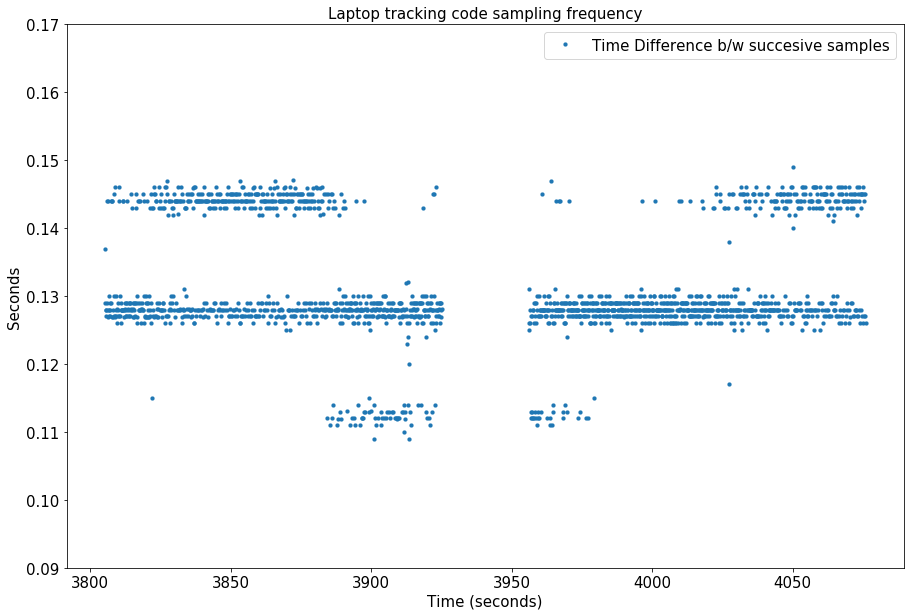

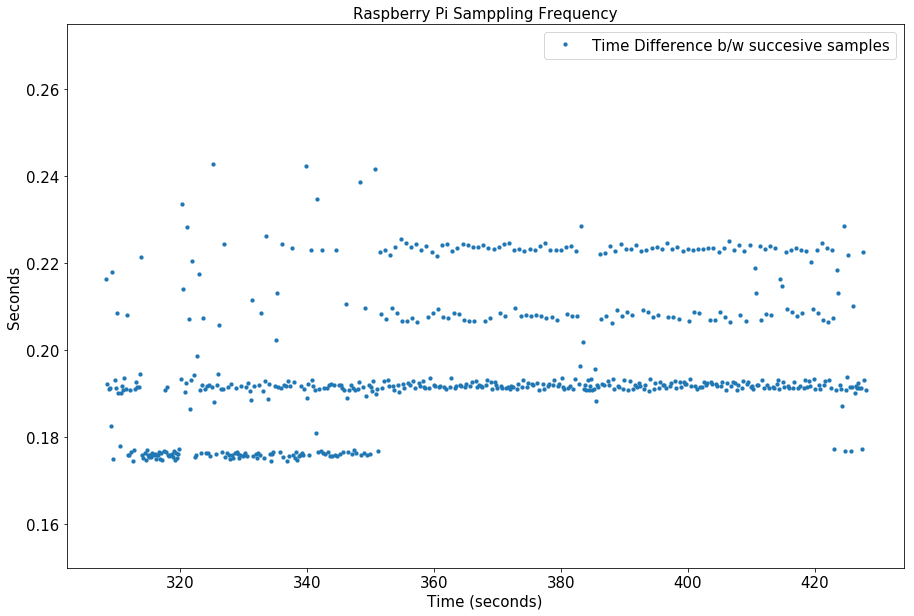

In [5]:
#Plot the time difference between successive data points
#Laptop tracking running ~7.6hz
start=3803
stop=4079
mask = (data_all_ss1['elapsed'] > start) & (data_all_ss1['elapsed'] < stop)
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'diff']
plt.plot(x,y,'o',label='Time Difference b/w succesive samples')
plt.title('Laptop tracking code sampling frequency')
plt.xlabel('Time (seconds)')
plt.ylabel('Seconds')
plt.ylim((0.09,0.17))
plt.legend()

#Tracking on raspberry pi running ~5hz
plt.figure()
start=305
stop=430
mask = (data_rpi_all_ss1['elapsed'] > start) & (data_rpi_all_ss1['elapsed'] < stop)
x=data_rpi_all_ss1.loc[mask,'elapsed']
y=data_rpi_all_ss1.loc[mask,'diff']
plt.plot(x,y,'o',label='Time Difference b/w succesive samples')
plt.title('Raspberry Pi Samppling Frequency')
plt.xlabel('Time (seconds)')
plt.ylabel('Seconds')
plt.ylim((0.150,0.275))
plt.legend()

## Tracking was running without electronic shims

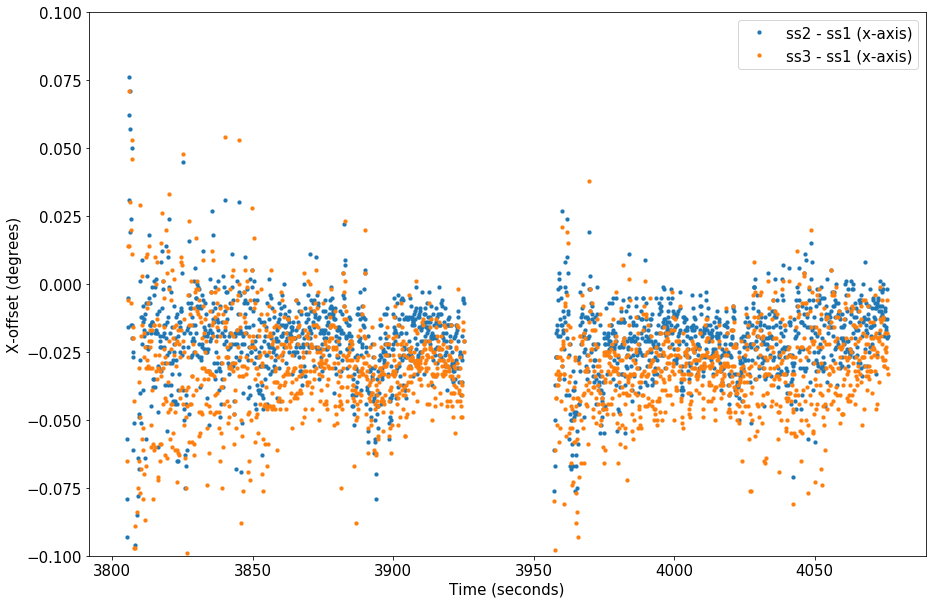

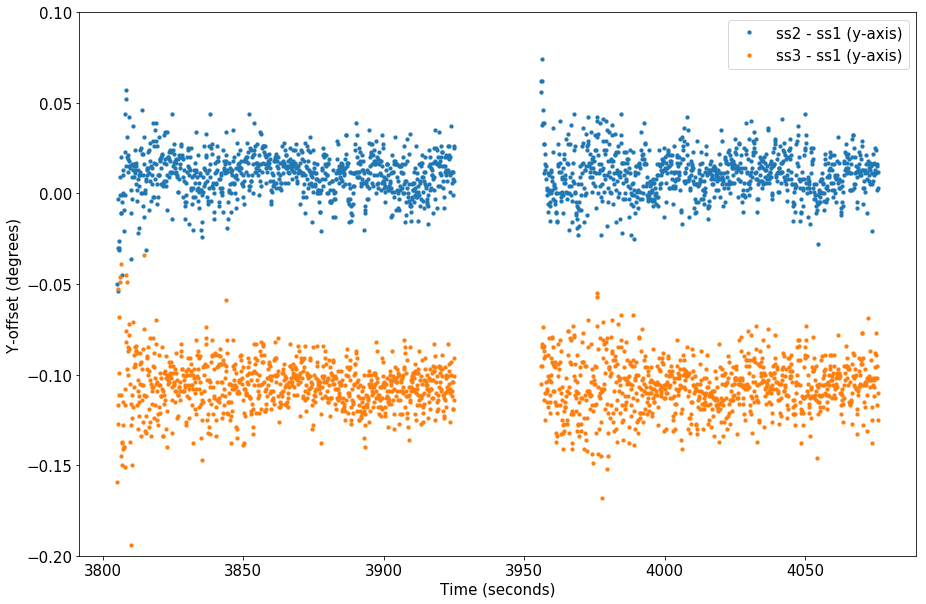

In [6]:
#Plot the x-angle offset difference between sun sunsors
plt.figure()
start=3800
stop=4100
mask = (data_all_ss1['elapsed'] > start) & (data_all_ss1['elapsed'] < stop)
x=data_all_ss1.loc[mask,'elapsed']
y2_1=data_all_ss2.loc[mask,'ang_x_raw'] - data_all_ss1.loc[mask,'ang_x_raw']
y3_1=data_all_ss3.loc[mask,'ang_x_raw'] - data_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y2_1,'o',label='ss2 - ss1 (x-axis)')
plt.plot(x,y3_1,'o',label='ss3 - ss1 (x-axis)')
plt.ylim((-0.1,0.1))
plt.xlabel('Time (seconds)')
plt.ylabel('X-offset (degrees)')
plt.legend()

#Plot the y-angle offset difference between sun sunsors
plt.figure()
y2_1=data_all_ss2.loc[mask,'ang_y_raw'] - data_all_ss1.loc[mask,'ang_y_raw']
y3_1=data_all_ss3.loc[mask,'ang_y_raw'] - data_all_ss1.loc[mask,'ang_y_raw']
plt.plot(x,y2_1,'o',label='ss2 - ss1 (y-axis)')
plt.plot(x,y3_1,'o',label='ss3 - ss1 (y-axis)')
plt.ylim((-0.2,0.1))
plt.xlabel('Time (seconds)')
plt.ylabel('Y-offset (degrees)')
plt.legend()

# Runs with 210 lbs tracked significantly better than runs with 70lbs

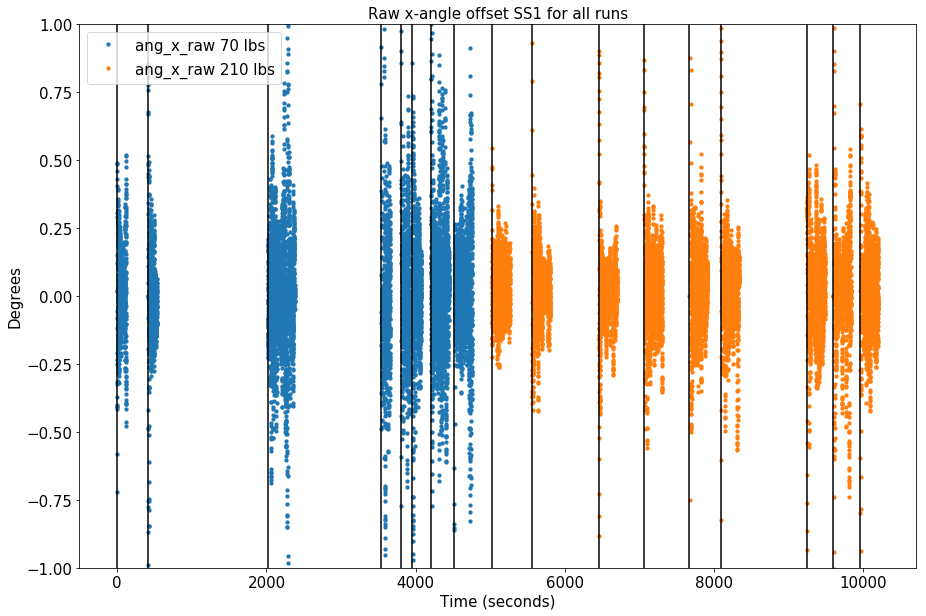

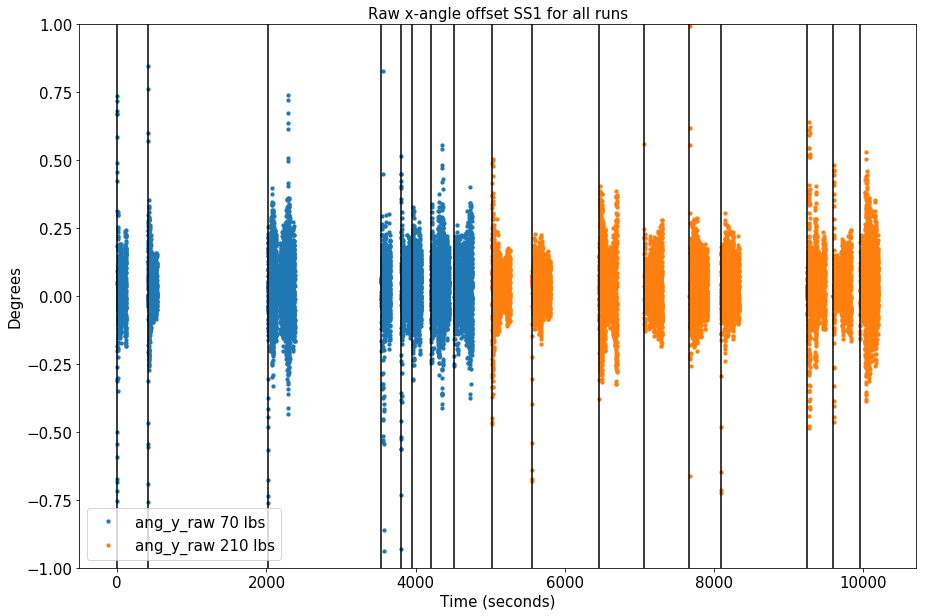

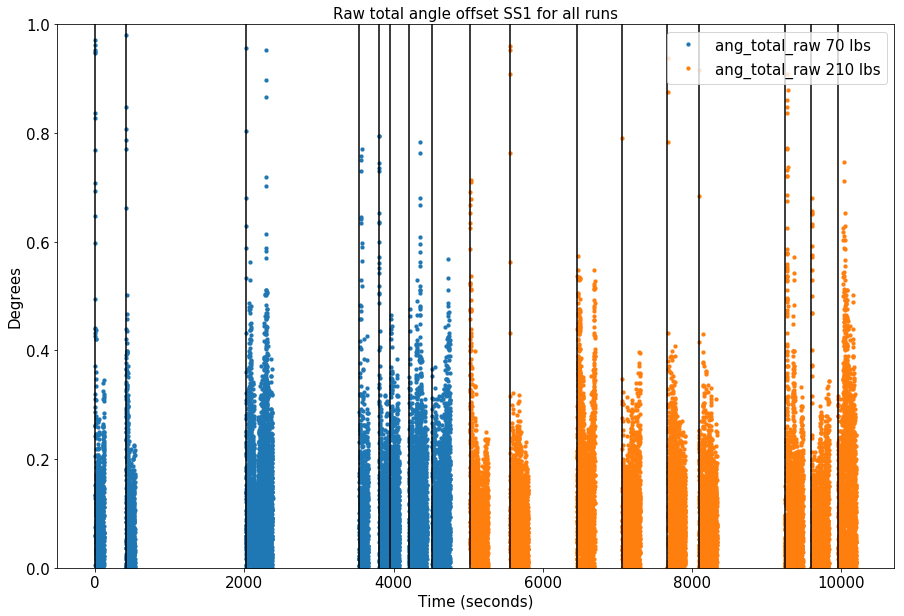

In [8]:
#Plot raw x-angle offset for SS1 for all runs
#It is clear that the added weights helped the tracking significantly
plt.figure()
start=0
stop=data_all_ss1['elapsed'][-1]
mask_70 = data_all_ss1['run'] <= 8
mask_210 = data_all_ss1['run'] > 8
x_70=data_all_ss1.loc[mask_70,'elapsed']
x_210=data_all_ss1.loc[mask_210,'elapsed']
y_70=data_all_ss1.loc[mask_70,'ang_x_raw']
y_210=data_all_ss1.loc[mask_210,'ang_x_raw']
plt.plot(x_70,y_70,'o',label='ang_x_raw 70 lbs')
plt.plot(x_210,y_210,'o',label='ang_x_raw 210 lbs')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
for i in range(data_all_ss1['run'].max()):
    mask_run=data_all_ss1['run'] == i+1
    plt.axvline(data_all_ss1.loc[mask_run,'elapsed'][0],color='k')
plt.title('Raw x-angle offset SS1 for all runs')
plt.ylim((-1,1))
plt.legend()

plt.figure()
y_70=data_all_ss1.loc[mask_70,'ang_y_raw']
y_210=data_all_ss1.loc[mask_210,'ang_y_raw']
plt.plot(x_70,y_70,'o',label='ang_y_raw 70 lbs')
plt.plot(x_210,y_210,'o',label='ang_y_raw 210 lbs')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
for i in range(data_all_ss1['run'].max()):
    mask_run=data_all_ss1['run'] == i+1
    plt.axvline(data_all_ss1.loc[mask_run,'elapsed'][0],color='k')
plt.title('Raw x-angle offset SS1 for all runs')
plt.ylim((-1,1))
plt.legend()

plt.figure()
y_70=np.sqrt(data_all_ss1.loc[mask_70,'ang_y_raw']**2 + data_all_ss1.loc[mask_70,'ang_y_raw']**2)
y_210=np.sqrt(data_all_ss1.loc[mask_210,'ang_y_raw']**2 + data_all_ss1.loc[mask_210,'ang_y_raw']**2)
plt.plot(x_70,y_70,'o',label='ang_total_raw 70 lbs')
plt.plot(x_210,y_210,'o',label='ang_total_raw 210 lbs')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
for i in range(data_all_ss1['run'].max()):
    mask_run=data_all_ss1['run'] == i+1
    plt.axvline(data_all_ss1.loc[mask_run,'elapsed'][0],color='k')
plt.title('Raw total angle offset SS1 for all runs')
plt.ylim((0,1))
plt.legend()

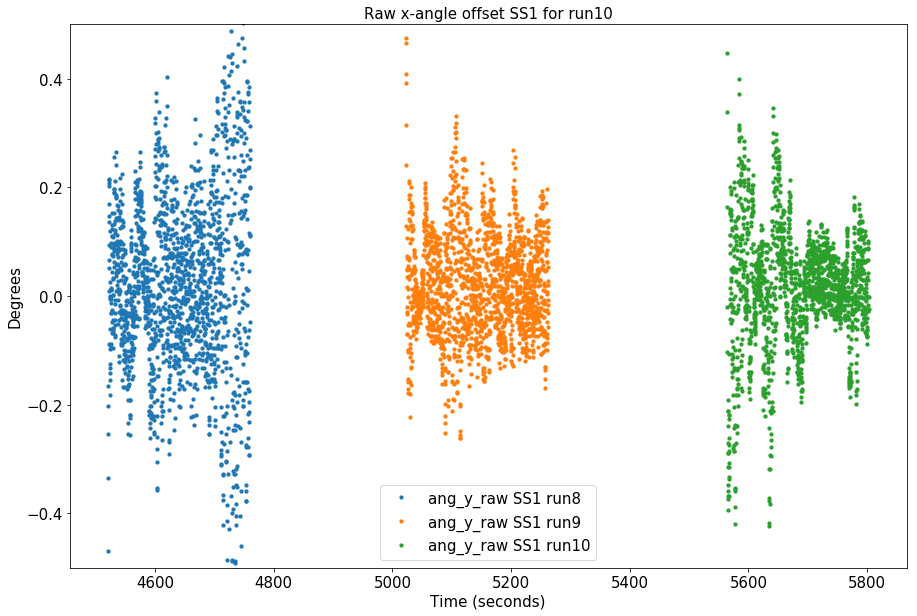

In [9]:
#Plot data for run 8,9,10
plt.plot()
run=8
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y,'o',label='ang_y_raw SS1 run'+str(run))
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.5,0.5))
plt.legend()

plt.plot()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y,'o',label='ang_y_raw SS1 run'+str(run))
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.5,0.5))
plt.legend()

plt.plot()
run=10
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y,'o',label='ang_y_raw SS1 run'+str(run))
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.5,0.5))
plt.legend()

# Run 9: Tracking kept sun within 0.1deg for 47% of the time

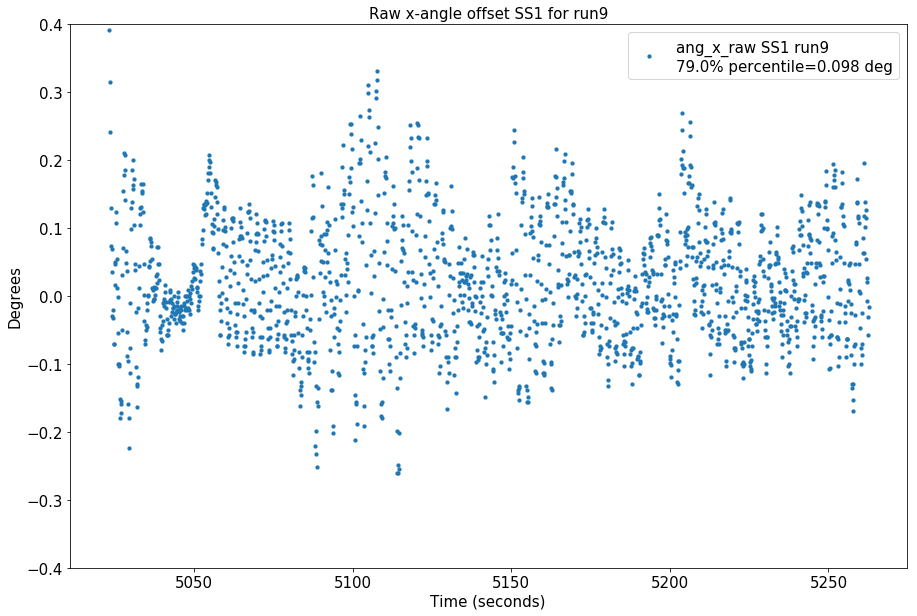

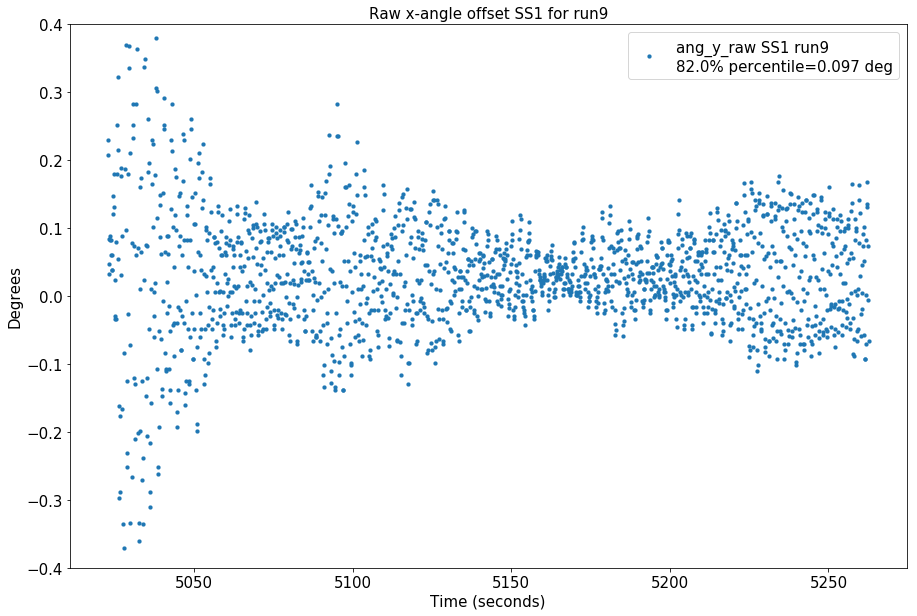

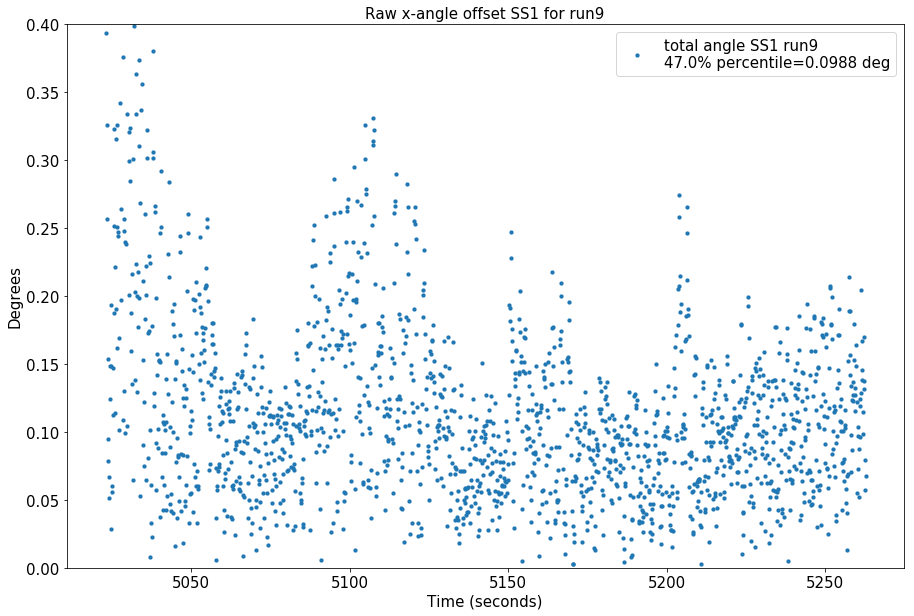

In [10]:
plt.figure()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'ang_x_raw']
percentile=0.79
p=str(round(y.quantile(percentile),4))
plt.plot(x,y,'o',label='ang_x_raw SS1 run'+str(run)+'\n'+str(percentile*100)+'% percentile='+p+' deg')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.4,0.4))
plt.legend()

plt.figure()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=data_all_ss1.loc[mask,'ang_y_raw']
percentile=0.82
p=str(round(y.quantile(percentile),4))
plt.plot(x,y,'o',label='ang_y_raw SS1 run'+str(run)+'\n'+str(percentile*100)+'% percentile='+p+' deg')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.4,0.4))
plt.legend()

#Plot data for run 9: tracking within 0.1deg for 47% of time
plt.figure()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y=np.sqrt(data_all_ss1.loc[mask,'ang_x_raw']**2+data_all_ss1.loc[mask,'ang_y_raw']**2)
percentile=0.47
p=str(round(y.quantile(percentile),4))
plt.plot(x,y,'o',label='total angle SS1 run'+str(run)+'\n'+str(percentile*100)+'% percentile='+p+' deg')
plt.xlabel('Time (seconds)')
plt.ylabel('Degrees')
plt.title('Raw x-angle offset SS1 for run'+str(run))
plt.ylim((-0.0,0.4))
plt.legend()

(-0.4, 0.4)

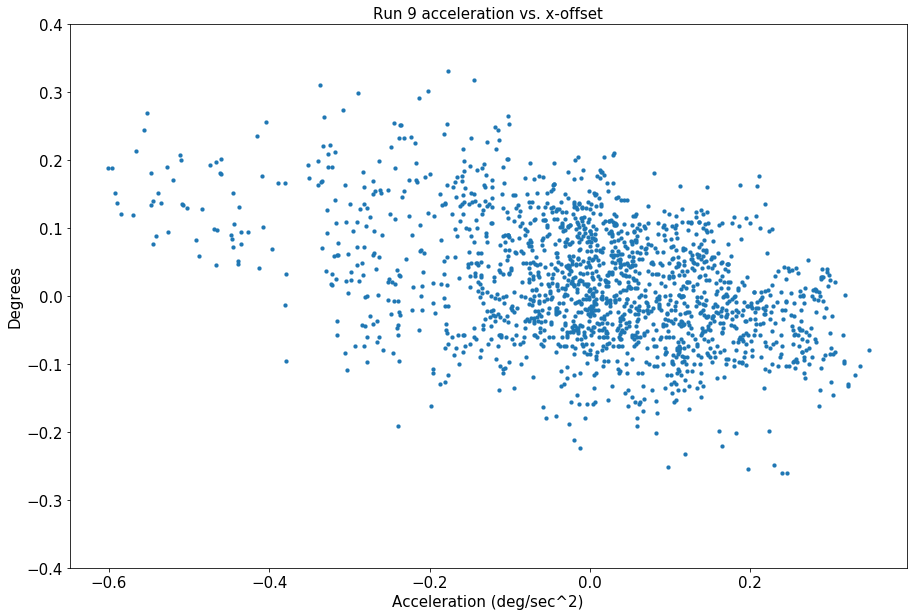

In [11]:
#Plot data for run 9: accel vs. x-offset
plt.plot()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'accel']
y=data_all_ss1.loc[mask,'ang_x_raw']
percentile=0.47
p=str(round(y.quantile(percentile),4))
plt.plot(x,y,'o')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run '+str(run)+' acceleration vs. x-offset')
plt.ylim((-0.4,0.4))

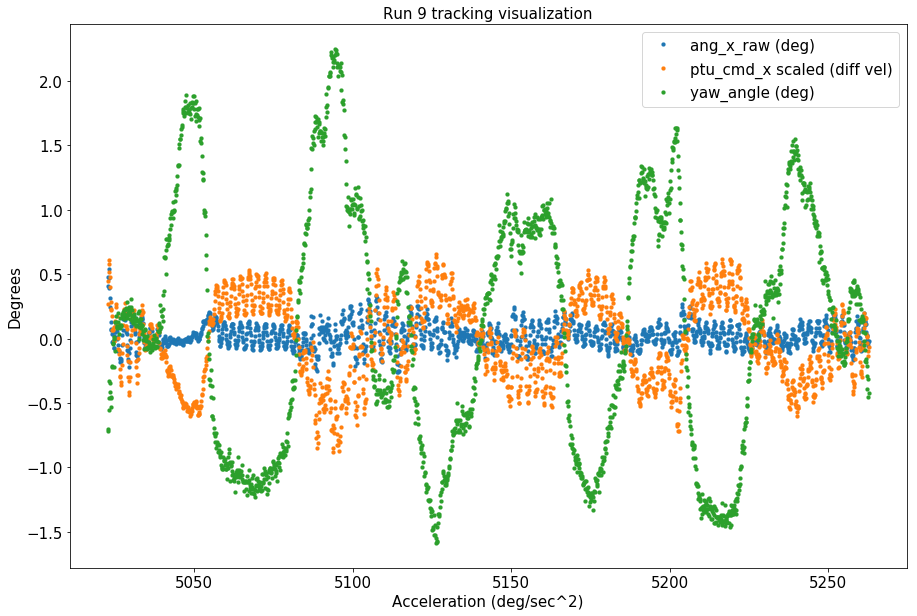

In [12]:
#Plot tracking data for run 9: ang_x_offset,ptu_cmd_x,yaw_angle
plt.plot()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'elapsed']
y1=data_all_ss1.loc[mask,'ang_x_raw']
y2=data_all_ss1.loc[mask,'ptu_cmd_x']/500.
y3=data_all_ss1.loc[mask,'imu_ang_z']
plt.plot(x,y1,'o',label='ang_x_raw (deg)')
plt.plot(x,y2,'o',label='ptu_cmd_x scaled (diff vel)')
plt.plot(x,y3,'o',label='yaw_angle (deg)')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run '+str(run)+' tracking visualization')
plt.legend()

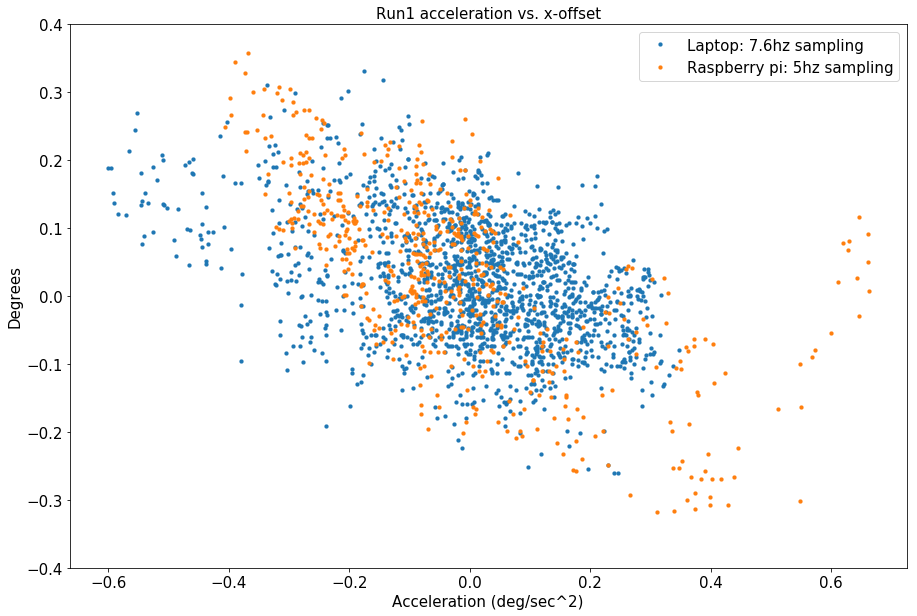

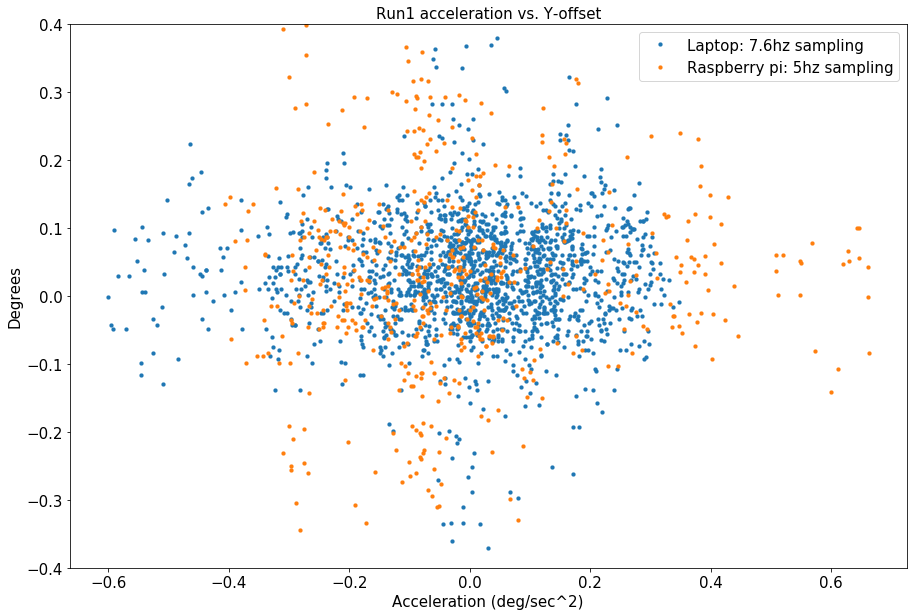

In [13]:
#Plot accel vs. x_offset for laptop and rasperry pi
#Rasperry pi is running with a slower sampling rate and appears to have a steeper slope (more sensitive to accelerations)
#This hopefuly means that fixing the code to run at 20hz will decrease the slope even further
plt.figure()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'accel']
y=data_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y,'o',label='Laptop: 7.6hz sampling')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run '+str(run)+' acceleration vs. x-offset')
plt.ylim((-0.4,0.4))

run=1
mask = data_rpi_all_ss1['run'] == run
x=data_rpi_all_ss1.loc[mask,'accel']
y=data_rpi_all_ss1.loc[mask,'ang_x_raw']
plt.plot(x,y,'o',label='Raspberry pi: 5hz sampling')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run'+str(run)+' acceleration vs. x-offset')
plt.ylim((-0.4,0.4))
plt.legend()


#Plot accel vs. Y_offset for laptop and rasperry pi
plt.figure()
run=9
mask = data_all_ss1['run'] == run
x=data_all_ss1.loc[mask,'accel']
y=data_all_ss1.loc[mask,'ang_y_raw']
plt.plot(x,y,'o',label='Laptop: 7.6hz sampling')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run '+str(run)+' acceleration vs. X-offset')
plt.ylim((-0.4,0.4))

run=1
mask = data_rpi_all_ss1['run'] == run
x=data_rpi_all_ss1.loc[mask,'accel']
y=data_rpi_all_ss1.loc[mask,'ang_y_raw']
plt.plot(x,y,'o',label='Raspberry pi: 5hz sampling')
plt.xlabel('Acceleration (deg/sec^2)')
plt.ylabel('Degrees')
plt.title('Run'+str(run)+' acceleration vs. Y-offset')
plt.ylim((-0.4,0.4))
plt.legend()

Laptop Stats 95th percentile
run 1 x-off= 0.2532 y-off= 0.157 kpx= 1.2 kpy= -1.2 kdx= 0.3 kdy= -0.3
run 2 x-off= 0.225 y-off= 0.141 kpx= 1.2 kpy= -1.2 kdx= 0.0 kdy= -0.0
run 3 x-off= 0.467 y-off= 0.232 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 4 x-off= 0.4115 y-off= 0.1803 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 5 x-off= 0.3901 y-off= 0.1601 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 6 x-off= 0.2547 y-off= 0.1844 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 7 x-off= 0.4398 y-off= 0.2078 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 8 x-off= 0.3176 y-off= 0.2006 kpx= 0.6 kpy= -0.6 kdx= 0.6 kdy= -0.6
run 9 x-off= 0.175 y-off= 0.137 kpx= 0.6 kpy= -0.6 kdx= 0.6 kdy= -0.6
run 10 x-off= 0.1888 y-off= 0.147 kpx= 0.3 kpy= -0.3 kdx= 0.3 kdy= -0.3
run 11 x-off= 0.1353 y-off= 0.2433 kpx= 0.4 kpy= -0.4 kdx= 0.2 kdy= -0.2
run 12 x-off= 0.1999 y-off= 0.168 kpx= 0.4 kpy= -0.5 kdx= 0.3 kdy= -0.4
run 13 x-off= 0.2229 y-off= 0.176 kpx= 0.5 kpy= -0.5 kdx= 0.4 kdy= -0.5
run 14 x-off= 0.173 y-off= 0.1601 kpx= 0.

{'boxes': [<matplotlib.lines.Line2D at 0x1c757068c88>,
 'caps': [<matplotlib.lines.Line2D at 0x1c757205748>,
 'fliers': [<matplotlib.lines.Line2D at 0x1c757236c88>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1c757236f60>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1c757068f28>,
  <matplotlib.lines.Line2D at 0x1c75c7ecb00>]}

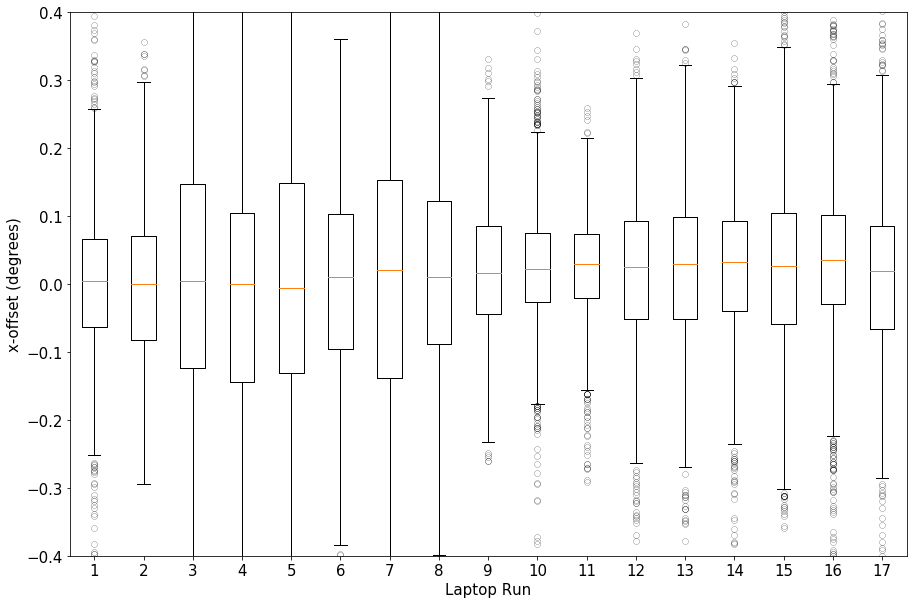

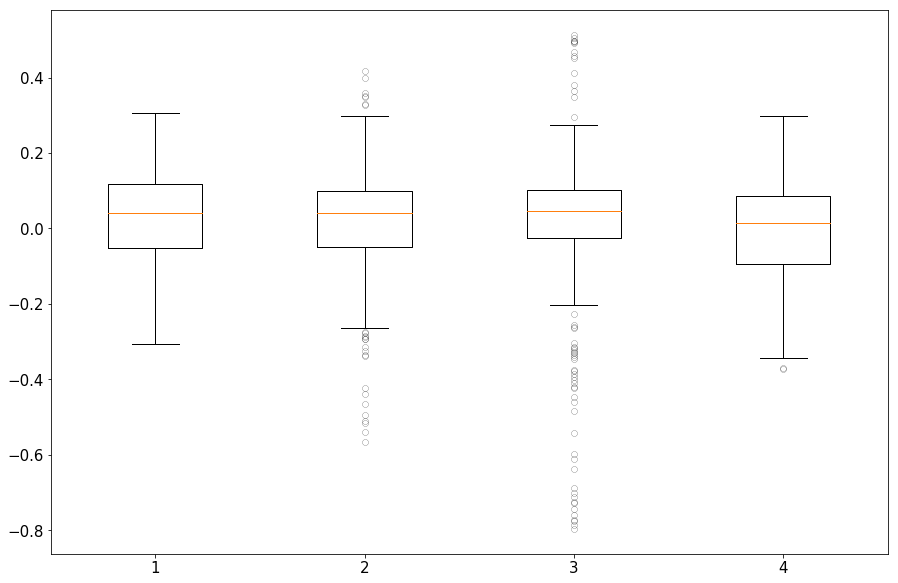

In [18]:
print('Laptop Stats 95th percentile')
plt.figure()
bp=[] #list to store boxplots in
for i in range(data_all_ss1['run'].max()):
    mask = (data_all_ss1['run'] == i+1)
    delay = int(7.6*20)  #Allow for 20 second settling period
    percentile=0.95
    p_x=round(data_all_ss1.loc[mask,'ang_x_raw'][delay:].quantile(percentile),4)
    p_y=round(data_all_ss1.loc[mask,'ang_y_raw'][delay:].quantile(percentile),4)
    print('run',i+1,
          'x-off=',p_x,
          'y-off=',p_y,
          'kpx=',data_all_ss1.loc[mask,'kpx'][0],
          'kpy=',data_all_ss1.loc[mask,'kpy'][0],
          'kdx=',data_all_ss1.loc[mask,'kdx'][0],
          'kdy=',data_all_ss1.loc[mask,'kdy'][0])
    bp.append(data_all_ss1.loc[mask,'ang_x_raw'][delay:])
plt.boxplot(bp) #plot boxplots of all data
plt.ylim((-0.4,0.4))
plt.xlabel('Laptop Run')
plt.ylabel('x-offset (degrees)')

print('')
print('Raspberry Pi Stats 95th percentile')  
plt.figure() 
bp=[] #list to store boxplots in
for i in range(data_rpi_all_ss1['run'].max()):
    mask = (data_rpi_all_ss1['run'] == i+1)
    delay = int(7.6*20)  #Allow for 20 second settling period
    percentile=0.95
    p_x=round(data_rpi_all_ss1.loc[mask,'ang_x_raw'][delay:].quantile(percentile),4)
    p_y=round(data_rpi_all_ss1.loc[mask,'ang_y_raw'][delay:].quantile(percentile),4)
    print('run',i+1,
          'x-off=',p_x,
          'y-off=',p_y,
          'kpx=',data_rpi_all_ss1.loc[mask,'kpx'][0],
          'kpy=',data_rpi_all_ss1.loc[mask,'kpy'][0],
          'kdx=',data_rpi_all_ss1.loc[mask,'kdx'][0],
          'kdy=',data_rpi_all_ss1.loc[mask,'kdy'][0])
    bp.append(data_rpi_all_ss1.loc[mask,'ang_x_raw'][delay:])
plt.boxplot(bp) #plot boxplots of all data